# Waste Free SMC comparison

In this notebook we take again a Logistic Regression model, and compare MH, SMC and Waste-Free SMC

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import sklearn

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (12, 8)
import jax

from datetime import date
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))
import jax.numpy as jnp
from sklearn.datasets import make_biclusters
import blackjax

## The Data

In [3]:
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

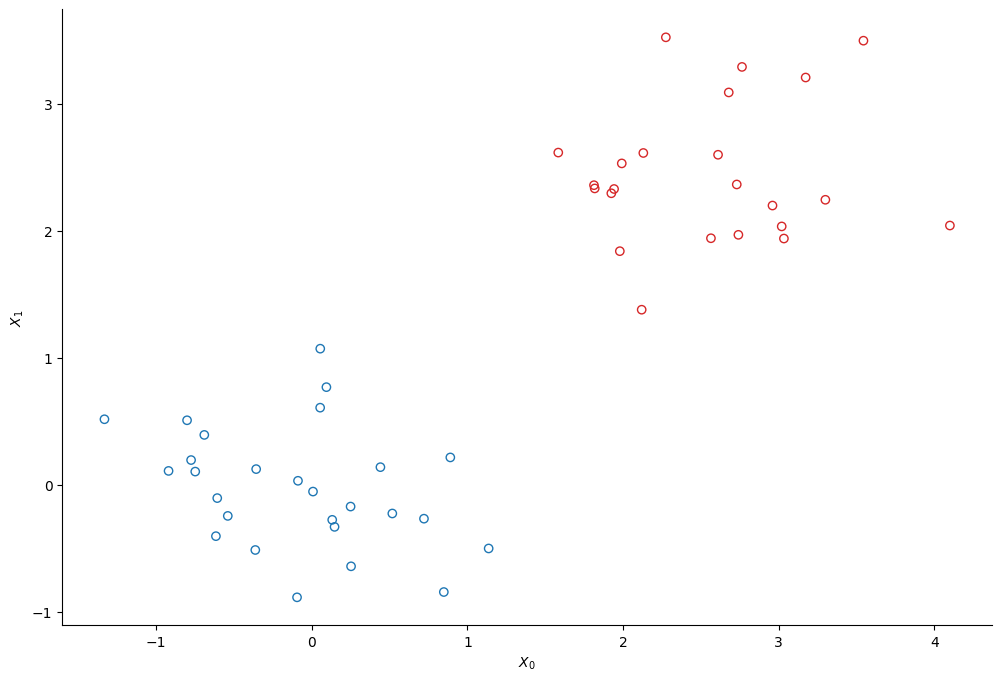

In [4]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$");

## The Model

We use a simple logistic regression model to infer to which cluster each of the points belongs. We note $y$ a binary variable that indicates whether a point belongs to the first cluster :

$$
y \sim \operatorname{Bernoulli}(p)
$$

The probability $p$ to belong to the first cluster commes from a logistic regression:

$$
p = \operatorname{logistic}(\Phi\,\boldsymbol{w})
$$

where $w$ is a vector of weights whose priors are a normal prior centered on 0:

$$
\boldsymbol{w} \sim \operatorname{Normal}(0, \sigma)
$$

And $\Phi$ is the matrix that contains the data, so each row $\Phi_{i,:}$ is the vector $\left[1, X_0^i, X_1^i\right]$

Note that X is not normalized

In [5]:
Phi = jnp.c_[jnp.ones(num_points)[:, None], X]
N, M = Phi.shape


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))

def logprior(w, alpha=0.01):
    prior_term = alpha * w @ w / 2
    return -prior_term
    
def loglikelihood(w):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))
    return log_likelihood_term.sum()
    
def logdensity_fn(w, alpha=0.01):
    return logprior(w,alpha) + loglikelihood(w)

Text(0.5, 1.0, 'Prior')

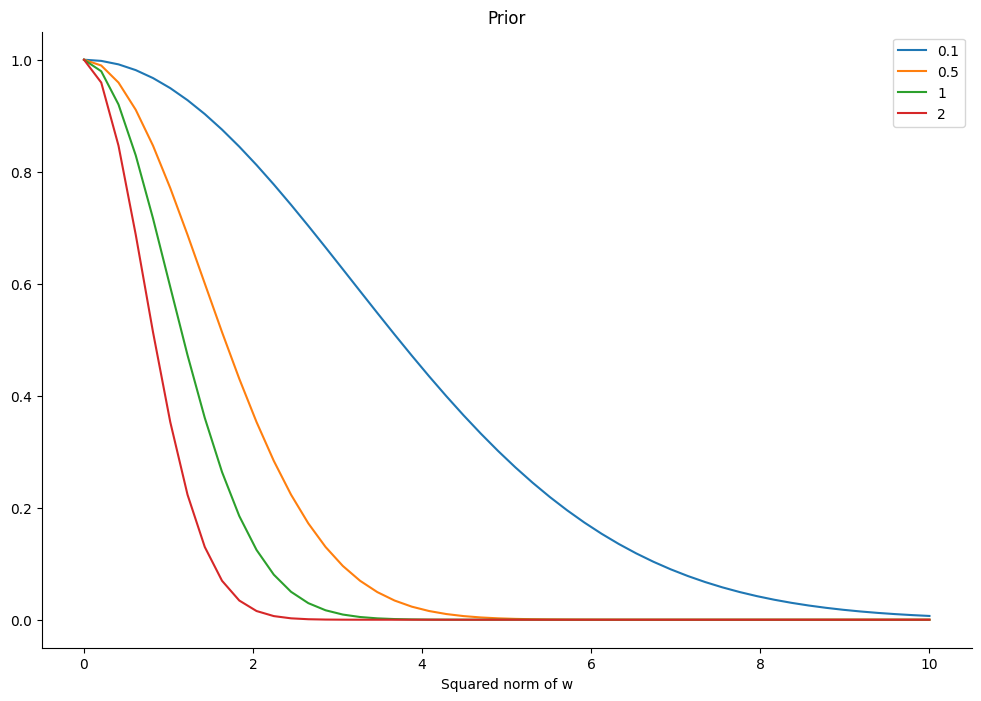

In [6]:
w = jnp.linspace(0, 10).reshape(-1,1)
for alpha in [0.1, 0.5, 1, 2]:
    plt.plot(w, jax.vmap(lambda x:jnp.exp(logprior(x, alpha)))(w), label=alpha)

plt.legend()
plt.xlabel("Squared norm of w")
plt.title("Prior")

In [7]:
from sklearn.linear_model import LogisticRegression

## Posterior Sampling

We use `blackjax`'s Random Walk RMH kernel to sample from the posterior distribution.

In [8]:
rng_key, init_key = jax.random.split(rng_key)

w0 = jax.random.multivariate_normal(init_key, 0.1 + jnp.zeros(M), jnp.eye(M))
rmh = blackjax.rmh(logdensity_fn, blackjax.mcmc.random_walk.normal(jnp.ones(M) * 0.05))
initial_state = rmh.init(w0)

def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

rng_key, sample_key = jax.random.split(rng_key)
states = inference_loop(sample_key, rmh.step, initial_state, 5_000)

Trace display:

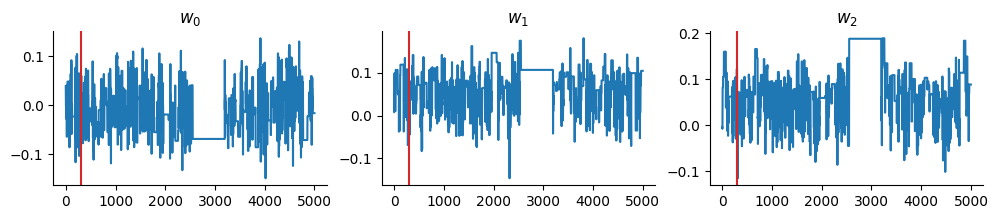

In [9]:
burnin = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.position[:, i])
    axi.set_title(f"$w_{i}$")
    axi.axvline(x=burnin, c="tab:red")
plt.show()

In [10]:
burnin = 300
chains = states.position[burnin:, :]
nsamp, _ = chains.shape

# Classic SMC

In [11]:
import jax.numpy as jnp
import numpy as np

from blackjax import adaptive_tempered_smc
from blackjax.smc import resampling, extend_params
from blackjax.smc.inner_kernel_tuning import StateWithParameterOverride
from blackjax.smc.tempered import TemperedSMCState
import jax
from jax import numpy as jnp
from datetime import date
import numpy as np
import pandas as pd
import functools
from jax.scipy.stats import multivariate_normal
from blackjax import additive_step_random_walk, inner_kernel_tuning
from blackjax.mcmc.random_walk import normal
from blackjax.smc.tuning.from_particles import (
    particles_covariance_matrix
)

n_predictors = 3
def initial_particles_multivariate_normal(key, n_samples):
    return jax.random.multivariate_normal(
        key, jnp.zeros(n_predictors) + 0.1, jnp.eye(n_predictors), (n_samples,)
    )

In [12]:
n_particles = 20000
key = jax.random.PRNGKey(10)
key, initial_particles_key, iterations_key = jax.random.split(key, 3)
initial_particles = initial_particles_multivariate_normal(initial_particles_key, n_particles)
initial_parameter_value = extend_params({"cov": particles_covariance_matrix(initial_particles)})


def mcmc_parameter_update_fn(state: TemperedSMCState, info):
    sigma_particles = particles_covariance_matrix(state.particles) * 2.38 / np.sqrt(n_predictors) 
    return extend_params({"cov":sigma_particles})

def step_fn(key, state, logdensity, cov):
    return blackjax.rmh(logdensity, normal(cov)).step(key, state)


kernel_tuned_proposal = inner_kernel_tuning(
        logprior_fn=logprior,
        loglikelihood_fn=loglikelihood,
        mcmc_step_fn=step_fn,
        mcmc_init_fn=blackjax.rmh.init,
        resampling_fn=resampling.systematic,
        smc_algorithm=adaptive_tempered_smc,
        mcmc_parameter_update_fn=mcmc_parameter_update_fn,
        initial_parameter_value=initial_parameter_value,
        target_ess=0.5,
        num_mcmc_steps=5,
)

from blackjax.smc.base import SMCInfo
def loop(kernel, rng_key, initial_state):
    normalizing_constant = jnp.zeros((1000))

    def cond(carry):
        _, state, _ = carry
        return state.sampler_state.lmbda < 1

    def body(carry):
        i, state, op_key = carry
        op_key, subkey = jax.random.split(op_key, 2)
        state, info = kernel(subkey, state)
        normalizing_constant.at[i].set(info.log_likelihood_increment)
        return i + 1, state, op_key

    def f(initial_state, key):
        total_iter, final_state, _ = jax.lax.while_loop(
            cond, body, (0, initial_state, key)
        )
        return total_iter, final_state

    total_iter, final_state = f(initial_state, rng_key)
    return total_iter, final_state, normalizing_constant

In [13]:
total_steps, final_state, normalizing_constant = loop(kernel_tuned_proposal.step, iterations_key, kernel_tuned_proposal.init(initial_particles))

In [14]:
np.sum(normalizing_constant[:total_steps]) #

Array(0., dtype=float32)

In [15]:
np.exp(np.sum(normalizing_constant[:total_steps]))

np.float32(1.0)

Why the log normalizing constant is always 0? Is it because of the prior shape?

In [16]:
particles = final_state.sampler_state.particles

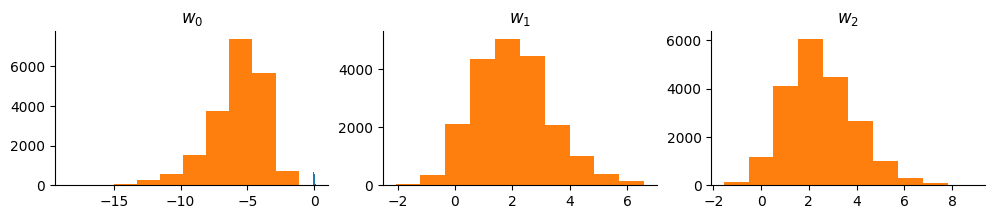

In [17]:
burnin = 300

fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.hist(states.position[burnin:, i])
    axi.hist(particles[:, i])
    axi.set_title(f"$w_{i}$")
plt.show()

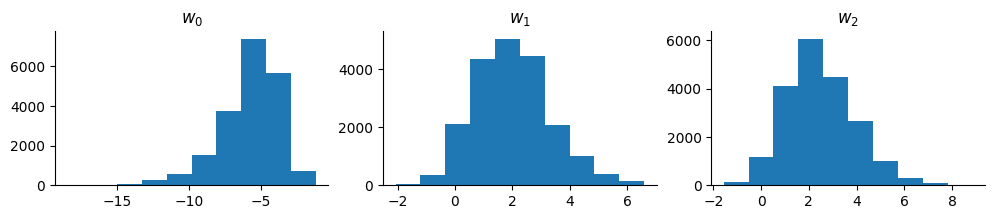

In [18]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.hist(particles[:, i])
    axi.set_title(f"$w_{i}$")
plt.show()

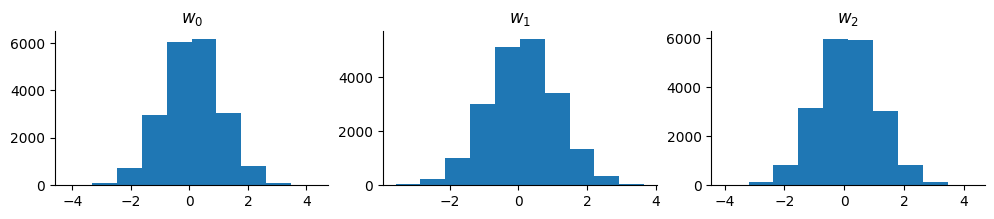

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.hist(initial_particles[:, i])
    axi.set_title(f"$w_{i}$")
plt.show()

In [20]:
def predict(x, w):
    return sigmoid(x@w)
    

In [21]:
pred=(predict(Phi,np.mean(particles, axis=0))>0.5).astype(int)

In [22]:
pred2=(predict(Phi,np.mean(states.position, axis=0))>0.5).astype(int)

In [23]:
import sklearn
sklearn.metrics.confusion_matrix(y, pred)

array([[27,  0],
       [ 0, 23]])

Above: confusion matrix for SMC in sample

In [24]:
sklearn.metrics.confusion_matrix(y, pred2)

array([[19,  8],
       [ 0, 23]])

Above: confusion matrix for MH in sample

In [25]:
def posterior_predictive_plot(samples):
    from matplotlib import cm, ticker
    xmin, ymin = X.min(axis=0) - 0.1
    xmax, ymax = X.max(axis=0) + 0.1
    step = 0.1
    Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
    _, nx, ny = Xspace.shape
    
    # Compute the average probability to belong to the first cluster at each point on the meshgrid
    Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])
    Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, samples))
    Z_mcmc = Z_mcmc.mean(axis=0)
    
    plt.contourf(*Xspace, Z_mcmc)
    plt.legend()
    plt.scatter(*X.T, c=colors)
    plt.xlabel(r"$X_0$")
    plt.ylabel(r"$X_1$")
    plt.show();
    return Z_mcmc

/tmp/ipykernel_62464/2150260783.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


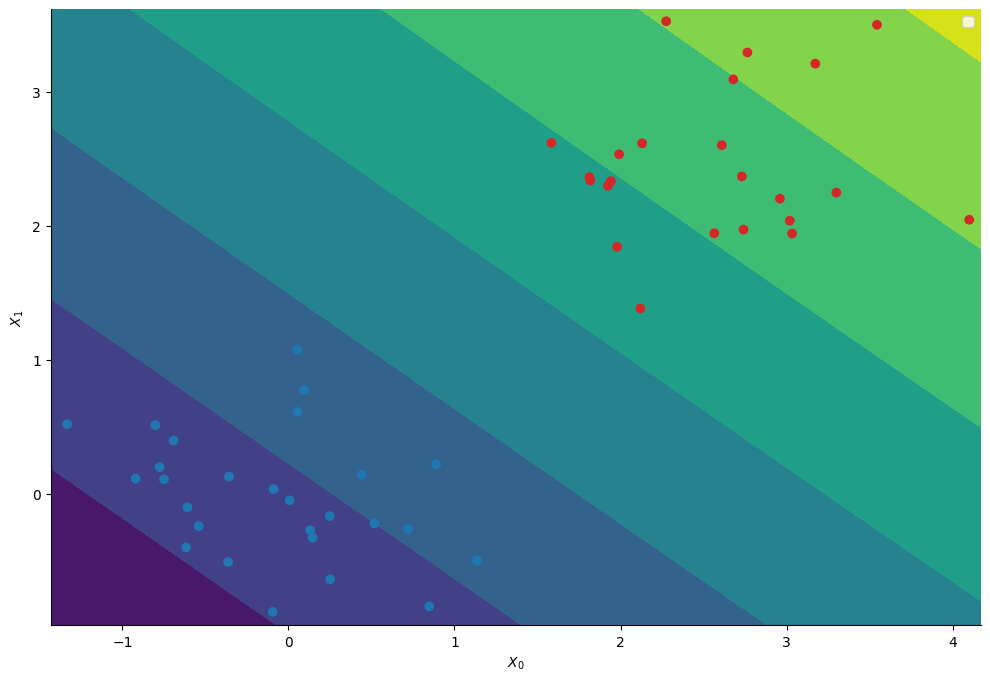

In [26]:
Z_mcmc = posterior_predictive_plot(chains)

In [27]:
Z_mcmc

Array([[0.4520933 , 0.4540293 , 0.45596862, ..., 0.53816384, 0.54008245,
        0.5419968 ],
       [0.4537641 , 0.45570213, 0.45764345, ..., 0.5398365 , 0.5417531 ,
        0.5436653 ],
       [0.4554368 , 0.45737684, 0.45931998, ..., 0.5415082 , 0.5434227 ,
        0.5453327 ],
       ...,
       [0.5430625 , 0.5450165 , 0.5469687 , ..., 0.6252578 , 0.6269905 ,
        0.6287157 ],
       [0.5447219 , 0.54667443, 0.54862505, ..., 0.62677556, 0.62850374,
        0.6302244 ],
       [0.54637897, 0.54832995, 0.55027884, ..., 0.62828875, 0.63001245,
        0.6317284 ]], dtype=float32)

It seems that MH as is implemented in the example assigns to all points probabilities around 45-65. Very close to 50%

/tmp/ipykernel_62464/2150260783.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


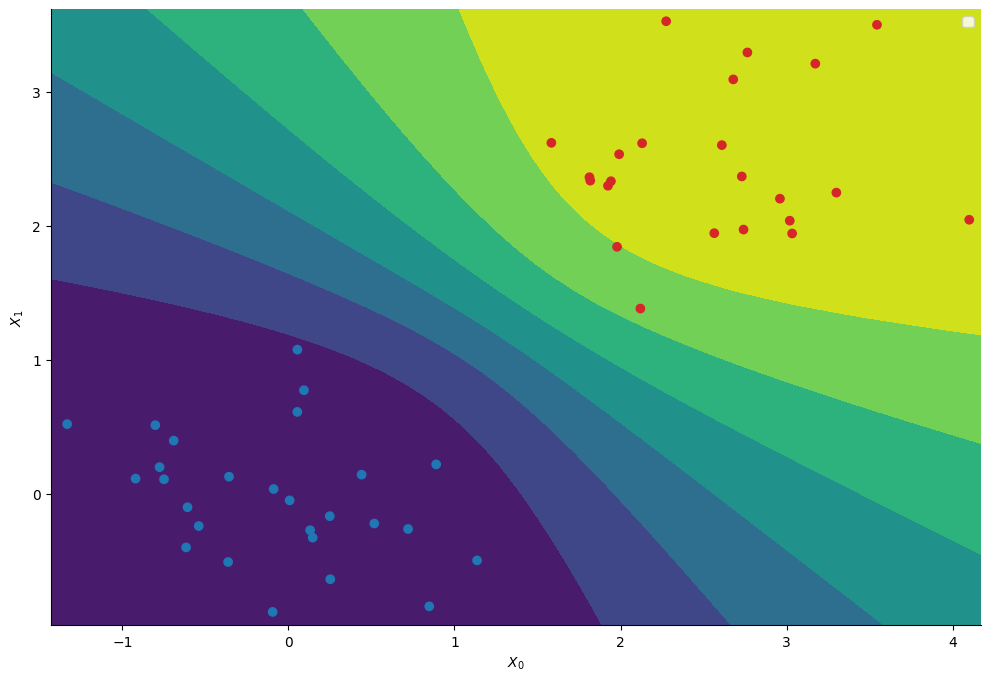

In [28]:
Z_mcmc_2 = posterior_predictive_plot(particles)

In [29]:
np.min(Z_mcmc_2), np.max(Z_mcmc_2)

(Array(0.0003122, dtype=float32), Array(0.99975044, dtype=float32))

# Waste-Free SMC

In [30]:
import importlib
importlib.reload(blackjax)
from blackjax.smc.waste_free import waste_free_smc

waste_free_smc_kernel = inner_kernel_tuning(
        logprior_fn=logprior,
        loglikelihood_fn=loglikelihood,
        mcmc_step_fn=step_fn,
        mcmc_init_fn=blackjax.rmh.init,
        resampling_fn=resampling.systematic,
        smc_algorithm=adaptive_tempered_smc,
        mcmc_parameter_update_fn=mcmc_parameter_update_fn,
        initial_parameter_value=initial_parameter_value,
        target_ess=0.5,
        num_mcmc_steps=None,
        update_strategy=waste_free_smc(n_particles,10)
)

In [31]:
total_steps_waste_free, final_state_waste_free, normalizing_constant_waste_free = loop(waste_free_smc_kernel.step, iterations_key, waste_free_smc_kernel.init(initial_particles))

In [32]:
np.sum(normalizing_constant_waste_free[:total_steps_waste_free]) #log scale

Array(0., dtype=float32)

/tmp/ipykernel_62464/2150260783.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


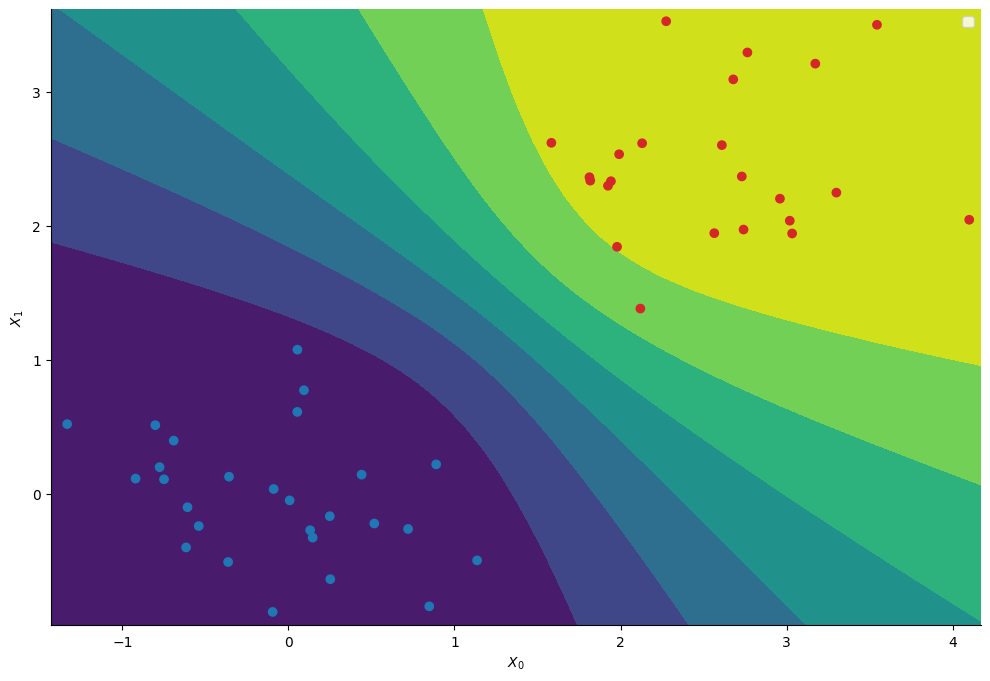

Array([[2.8918695e-04, 3.4526619e-04, 4.1533765e-04, ..., 4.1969481e-01,
        4.3220809e-01, 4.4416195e-01],
       [3.1954193e-04, 3.7984748e-04, 4.5493516e-04, ..., 4.3008462e-01,
        4.4261801e-01, 4.5457524e-01],
       [3.5531164e-04, 4.2049473e-04, 5.0137856e-04, ..., 4.4092900e-01,
        4.5347723e-01, 4.6544501e-01],
       ...,
       [5.7525760e-01, 5.8810079e-01, 6.0128236e-01, ..., 9.9963707e-01,
        9.9969530e-01, 9.9974197e-01],
       [5.8583021e-01, 5.9841263e-01, 6.1136401e-01, ..., 9.9966609e-01,
        9.9972129e-01, 9.9976534e-01],
       [5.9574318e-01, 6.0810667e-01, 6.2087506e-01, ..., 9.9969071e-01,
        9.9974334e-01, 9.9978501e-01]], dtype=float32)

In [33]:
posterior_predictive_plot(final_state_waste_free.sampler_state.particles)

In [34]:
particles_waste_free = final_state_waste_free.sampler_state.particles

/tmp/ipykernel_62464/4095671798.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


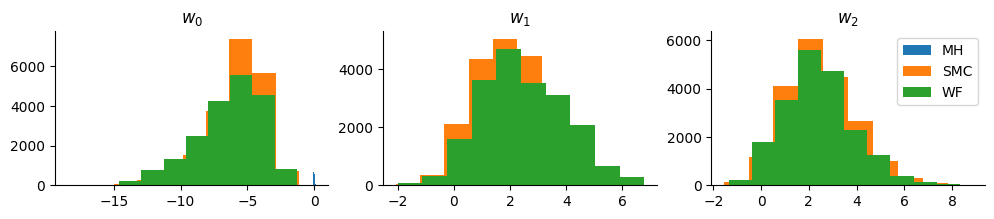

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.hist(chains[:,i], label="MH")
    axi.hist(particles[:, i], label="SMC")
    axi.hist(particles_waste_free[:, i],label="WF")
    

    axi.set_title(f"$w_{i}$")
    plt.legend()
plt.show()

There's a big difference in posteriors for SMC vs SMC-WasteFree

In [36]:
np.mean(chains[:,0]), np.mean(particles[:,0]), np.mean(particles_waste_free[:,0]), 

(Array(-0.01791389, dtype=float32),
 Array(-5.750385, dtype=float32),
 Array(-6.4010663, dtype=float32))

In [37]:
final_state_waste_free

StateWithParameterOverride(sampler_state=TemperedSMCState(particles=Array([[-6.385606 ,  2.3500376,  2.6450486],
       [-6.878158 ,  2.0022292,  4.137133 ],
       [-9.559358 ,  3.3078794,  2.0108054],
       ...,
       [-3.7246413,  3.2796614,  0.6937783],
       [-3.7246413,  3.2796614,  0.6937783],
       [-3.7246413,  3.2796614,  0.6937783]], dtype=float32), weights=Array([6.1977698e-05, 6.3779000e-05, 3.8251215e-05, ..., 4.2606887e-05,
       4.2606887e-05, 4.2606887e-05], dtype=float32), lmbda=Array(1., dtype=float32, weak_type=True)), parameter_override={'cov': Array([[[ 8.731909 , -2.2317386, -1.6413733],
        [-2.2317386,  3.0842333, -1.7759979],
        [-1.6413733, -1.7759979,  2.8467197]]], dtype=float32)})

Note that to achieve similar results, SMC will take

In [38]:
total_steps * 5 * n_particles

Array(1500000, dtype=int32, weak_type=True)

inner MCMC steps (with their corresponding density evaluations), whereas Waste-Free is going to take

In [39]:
total_steps_waste_free * n_particles/10 * 9 

Array(252000., dtype=float32, weak_type=True)

inner MCMC steps.

Confusion matrix in sample for waste free

In [40]:
pred3=(predict(Phi,np.mean(particles_waste_free, axis=0))>0.5).astype(int)
sklearn.metrics.confusion_matrix(y, pred3)

array([[27,  0],
       [ 0, 23]])